# Understanding Disagreements using RSA

---
This notebook is intended to be a 1:1 adaptation of the [RSA-Hyperbole Pyro Example Notebook](http://pyro.ai/examples/RSA-hyperbole.html) for the working example

It is also meant to serve as a functional (as opposed to object oriented) but otherwise identical implementation as the one in comp_implt.py

---
    <world knowledge> "§ 14-309.8.  Limit on sessions. The number of sessions of bingo conducted or sponsored by an exempt organization shall be limited to two sessions per week and such sessions must not exceed a period of five hours each per session." [US NC legislation](https://www.ncleg.net/EnactedLegislation/Statutes/HTML/ByArticle/Chapter_14/Article_37.html)
    
    <prosecution> "The defendant played at the bingo event for 7 hours straight."
    <defense> "At the mayfair."

---


Correcting a specific detail of what someone said is a common use of language possibly requiring logical inference during interpretation. I extend the RSA Model as used in [the Pyro Example](http://pyro.ai/examples/RSA-hyperbole.html) to include a logical theorem prover and allow non-literal probabilistic interpretation of corrections.

In [33]:
#first some imports
import torch
torch.set_default_dtype(torch.float64)  # double precision for numerical stability

import collections
import argparse

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine

from search_inference import factor, memoize
from phrasal import *
from helpers import *
rpc = wrapped_rpc

The domain for this example will be beliefs consisting of beliefs in first order logic form. More specifically, we will use a Neo-Davidsonian Event representation, so the event

    The chicken crossed the road at an intersection.
is normalized to:

    exists e. cross(e, chicken, road) & agn(e, chicken) & pat(e, road) & loc(e, intersection)
    
 
This representation lends itself both to logical inference about meaning and is compositionally built up so, associated attributes can be added together.
The implementation comes in the form a phrase class that provides an elementary cost attribute and builds up phrases incrementally from constituents. 
Priors here could be adapted from experimental data.

In the example, we are in court after Brutus murdered Caesar; two parties have different beliefs about how the event went down, one side first makes a statement how the event went down and then the other side interrupts (or decides not to). To avoid confusion it should be emphasized that the first person is the _Listener_ and the second person is the _Speaker_ as the Speech Act in focus is the correction.


A bit of prior setup is needed for this before we can turn to the RSA model. The world knowledge is provided in a list of FOL expressions. $k_{1-4}$ are specific conditions for punishment.

In [34]:
import nltk
expr = nltk.sem.Expression.fromstring

k1 = expr("all x.((exists e.(kill(e,x,y) & in(e,rome))) -> should_hang(x))")#killing in forum very illegal
k2 = expr("all x.((exists e.(kill(e,x,y))) -> mean(x))")#killing is mean
k3 = expr("all x.((exists e.(agn(e,x) & ins(e,knife))) -> should_be_lashed(x))")#using knife is slightly bad
k4 = expr("all x.((exists e.(loc(e,rubicon) & ins(e,paddle))) -> great(x))")#using paddle at rubicon is awesome

f1 = expr("all e.(loc(e,forum) -> in(e, rome))")
f2 = expr("all e.(loc(e,rubicon) -> -in(e, rome))")
f3 = expr("all e.(stab(e,x,y) -> kill(e,x,y))")

SWK = [k1,k2,k3,k4,f1,f2,f3]

The above shared world knowledge (swk) is shared in the sense that each of the two interlocutors 
1. knows these facts
2. knows the other knows them  
  
  
the listener furthermore also  
3. knows the speaker knows the listener knows them

In contrast, the following beliefs are specifically pertaining to the discussed event and may differ between the two.

In [45]:
from court import *

BELIEFs = [
         phrase([brutus, stab, caesar, forum, knife]),#prosecution belief
         phrase([brutus, stab, caesar, forum]),
         phrase([brutus, stab, caesar, knife]),
         phrase([brutus, stab, caesar, forum, knife]),
         phrase([brutus, stab, caesar, forum, sword]),
         phrase([brutus, stab, caesar, forum, knife]),
         phrase([brutus, stab, caesar, rubicon, sword]), 
         phrase([brutus, stab, caesar, rubicon]), 
         phrase([brutus, stab, caesar, sword]), 
         phrase([brutus, stab, caesar, sword, rubicon]),#defense belief
         phrase([brutus, stab, caesar, rubicon, knife]), 
         phrase([brutus, stab, caesar, rubicon, sword]), 
         phrase([caesar_ag, stab, brutus_pat, forum, knife]),
         phrase([brutus, stab, caesar, rubicon, knife, fun]),
         phrase([brutus, stab, caesar, rubicon, sword, others, fun]),
         phrase([brutus, row, boat, rubicon, paddle]),
         phrase([someone_else, stab, caesar, rubicon, knife])
      ]

def belief_prior(B): #over list
    ix = pyro.sample("belief", dist.Categorical(probs=torch.ones(len(B))/len(B)))
    return B[ix]

# try others (also in combination with different speaker qud below!)
listener_belief = BELIEFs[0]
speaker_belief = BELIEFs[9]

_BELIEFs_ is used to constrain the listener to consider only these possible speaker beliefs so the search space does not become too large.
Furthermore, the speaker uses the options in _BELIEFs_ to consider possible corrections.

Since both sides use this variable it is therefore important to make the distinction that the actual belief held by the respective sides is the central asymmetric aspect of the project, while the fact that both sides consider only event beliefs in _BELIEFs_ is symmetric.

Recall the $k_{1-4}$ which were introduced above; these are the respective conditions for the questions under discussion (QUDs) discussed by our prosecution and defense.

In [36]:
QUDs = {
        "hang": expr("should_hang(brutus)"),
        "mean": expr("mean(brutus)"),
        "lashed": expr("should_be_lashed(brutus)"),
        "great": expr("great(brutus)"),
}

def qud_prior(quds): #over dict
    keys = list(quds.keys())
    ix = pyro.sample("qud", dist.Categorical(probs=torch.ones(len(keys))/len(keys)))
    qud = keys[ix.item()]
    return qud

---
### The RSA Literal Listener

We can now turn to the literal listener ($L0$), which begins the chain of inference in the RSA model. $L0$ replaces the utterance in the listener belief according to the role the replacement has, then runs logical inference and finally produces a distribution over _beliefs_ 

The listener is defined mathematically by:

$$P_{L_0}(s|u) \propto  [[u]](s) \cdot P(s) $$


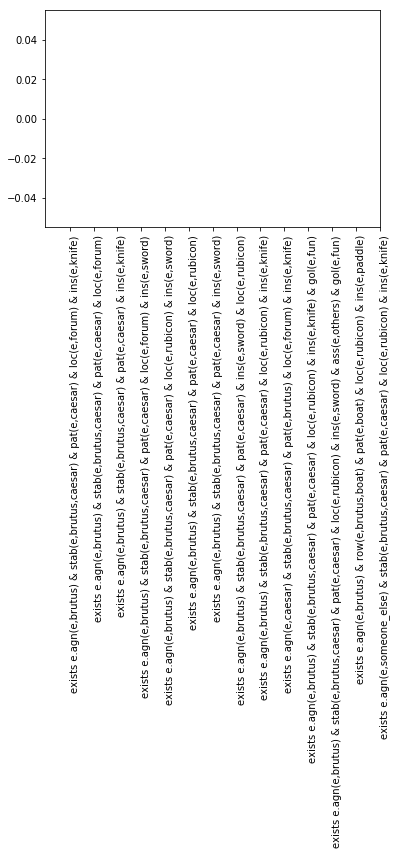

In [51]:
@Marginal
def L0(correction):

    interjector_belief=belief_prior(BELIEFs) #belief prior ~ state prior
    replacement = listener_belief.replace_constituents_in_utt(correction)
    if not type(correction) == NULL_Utt:
        added_expr = replacement
    else:
        added_expr = listener_belief
    evaluation = rpc(goal=interjector_belief.L(), assumptions=SWK+[added_expr.L()]).prove()

    factor("literal meaning", 0. if evaluation else float("-inf"))
    
    return interjector_belief

correction = phrase([rubicon]) #change to any phrase (see e.g. phrasal.py)

l0_dist = L0(correction)

#plotting adapted from RSA-hyperbole.ipynb:
def plot_dist(d):
    support = d.enumerate_support()
    data = [d.log_prob(s).exp().item() for s in d.enumerate_support()]
    names = support

    ax = plt.subplot(111)
    width=0.3
    bins = list(map(lambda x: x-width/2,range(1,len(data)+1)))
    ax.bar(bins,data,width=width)
    ax.set_xticks(list(map(lambda x: x, range(1,len(data)+1))))
    ax.set_xticklabels(names,rotation=90, rotation_mode="anchor", ha="right")

plot_dist(l0_dist)

The above plot shows the literal listeners interpretation of the utterance "At the rubicon.".

---
### The RSA Pragmatic Speaker
Is called $S_1$ and considers $L_0$'s interpretation of the utterances in $L_1$'s utterance prior. The utterance prior is reduced for computational tractability to the power set of the difference in assigned roles between the $L_0$ statement and $S_1$'s own belief. So, for example:

    <prosecution utterance> "exists e.agn(e,brutus) & stab(e,brutus,caesar) & pat(e,caesar) & loc(e,forum) & ins(e,knife)"
    <defense belief> "exists e.agn(e,brutus) & stab(e,brutus,caesar) & pat(e,caesar) & ins(e,sword) & loc(e,rubicon)"
    
    <utterance_prior return values>
        1.
        2.
        3.
        4.

In [49]:
@Memo
def utterance_prior(given_full_belief, smoke_utt=False):
    """

    if smoke_utt:
        sample from list of mock utterance values stochastically
    else:
        for all possible beliefs in belief_set:
            diff <= intersection of constituents in belief and givenbelief
            d <= powerset(diff)
        sample from union of all d

    """
    
    possible_changers = set()
    given_assigned = set(given_full_belief.assed.keys())

    if smoke_utt:
        possible_changers = [\
                phrase([phrasal.role("loc","rubicon", 1)]),\
                phrase([phrasal.role("loc","rubicon", 1),phrasal.role("ins", "sword",1)]),\
                phrase([phrasal.role("ins","sword", 1)]),\
                phrase([NULL_Utt()])]
    else:
        for belief in BELIEFs:
            assigned = set(belief.assed.keys())
            if assigned == {"NULL"}: #first leave out NULL utterances
                possible_changers.add(belief)
                continue
            diff_roles = [] #collect roles differently or not assigned in given belief
            for rol in assigned:
                if rol not in given_assigned:
                    diff_roles.append(rol)
                elif belief.assed[rol] != given_full_belief.assed[rol]:
                    diff_roles.append(rol)

            diff = [] #collect differing constituents together
            for const in belief.elems:
                for r in diff_roles:
                    if const.field == r:
                        diff += [const]
            if diff:
                d = phrase(diff) #difference in beliefs phrased fully
                combos = set(d.sub_utterances())
                possible_changers |= combos
        possible_changers = list(possible_changers)

    assert None not in possible_changers, "utterance prior incorrect"

    changerLogits = -torch.tensor([phr.cost for phr in possible_changers], dtype=torch.float32)
    ix = pyro.sample("utterance",dist.Categorical(logits=changerLogits))
    r = possible_changers[ix.item()]
    return r

_Adapted from RSA-hyperbole.ipynb_

---
Now we define a version of the RSA speaker that only produces *relevant* information for the literal listener. We define relevance with respect to a Question Under Discussion (QUD) -- this can be thought of as defining the speaker's current attention or topic.

The speaker is defined mathematically by:

$$P_S(u|b,q) \propto \left[ \sum_{b'} \delta_{q(b')=q(b)} P_\text{Lit}(b'|u) p(u) \right]^\alpha $$

To implement this as a probabilistic program, we start with a helper function `project`, which takes a distribution over some (discrete) domain and a function `qud` on this domain. It creates the push-forward distribution, using `Marginal` (as a Python decorator). The speaker's relevant information is then simply information about the state in this projection.

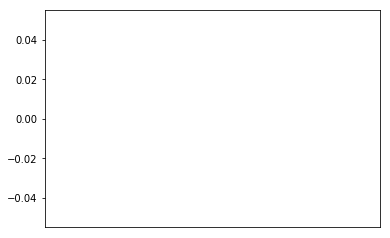

In [50]:
@Marginal
def interject(given_full_belief, qud, own_belief, alpha, smoke_s1=False):
    """
    
    Function of: given belief, own belief, qud
    
    Speaker decides wether to make a correction by inferring literal listener interpretation
    based on own question under discussion value
    and the opposing side's statement

    Args:
    """

    qudSelf = rpc(goal=QUDs[qud], assumptions=SWK+[own_belief.L()]).prove()


    with poutine.scale(scale=torch.tensor(float(alpha))):
        utterance = utterance_prior(given_full_belief, smoke_utt=smoke_s1)
        assert utterance != None

        #Construct Listener in head
        literal_marginal = L0(utterance)
        projected_literal = project(literal_marginal, qud)
        
        pyro.sample("listener", projected_literal, obs=qudSelf)
        
    return utterance

@Marginal
def project(dist,qud):
    """
    projection helper function so a hashingmarginal distribution can be used in interjection inference
    the speaker uses this projection to consider whether the literal listeners sampled
    interpretation satisfies the speakers QUD
    """
    v = pyro.sample("proj",dist)   
    qud_interp = rpc(goal=QUDs[qud],assumptions=SWK+[v.L()]).prove()

    return qud_interp

#speaker
alpha = 1. #try other values!
qud = "hang"
given_belief = listener_belief

s1_info = "Speaker distribution.\n\n- "+"Speaker event belief: "+str(speaker_belief)+"\n- "+"QUD: "+str(quds[qud])+"\n- alpha = "+str(alpha)

defense_attorney_dist = interject(given_belief, qud, speaker_belief, alpha, smoke_s1=True)
plot_dist(defense_attorney_dist)